In [2]:
# Requirements: mamba install tensorflow matplotlib scikit-learn numpy

import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, Rescaling


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/

'Colab Notebooks'   Data


In [5]:
DATA_DIR = "/content/drive/My Drive/Data"
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

print(train_dir)
print(val_dir)

/content/drive/My Drive/Data/train
/content/drive/My Drive/Data/val


In [6]:
def count_class_images(directory):
    counts = defaultdict(int)
    # List all class folders
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count all image files in class folder
            counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            print(f"{class_name}: {counts[class_name]} images")
    return counts

print("-----------------training dataset-----------------")
class_counts = count_class_images(train_dir)
print("--------------validation dataset----------------")
validation_class_counts = count_class_images(val_dir)


-----------------training dataset-----------------
Rice___Healthy: 1190 images
Wheat___Brown_Rust: 721 images
Potato___Early_Blight: 800 images
Potato___Late_Blight: 800 images
Wheat___Yellow_Rust: 739 images
Wheat___Healthy: 892 images
Corn___Northern_Leaf_Blight: 788 images
Potato___Healthy: 121 images
Corn___Common_Rust: 953 images
Rice___Brown_Spot: 490 images
Rice___Neck_Blast: 800 images
Corn___Healthy: 929 images
Rice___Leaf_Blast: 781 images
Corn___Gray_Leaf_Spot: 410 images
--------------validation dataset----------------
Potato___Early_Blight: 100 images
Wheat___Brown_Rust: 90 images
Rice___Leaf_Blast: 98 images
Wheat___Healthy: 112 images
Potato___Late_Blight: 100 images
Corn___Common_Rust: 119 images
Corn___Healthy: 116 images
Wheat___Yellow_Rust: 92 images
Corn___Northern_Leaf_Blight: 98 images
Rice___Brown_Spot: 61 images
Rice___Healthy: 149 images
Corn___Gray_Leaf_Spot: 51 images
Rice___Neck_Blast: 100 images
Potato___Healthy: 15 images


In [7]:
# Data pipeline
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_dataset.class_names
num_classes = len(class_names)

Found 10414 files belonging to 14 classes.
Found 1301 files belonging to 14 classes.


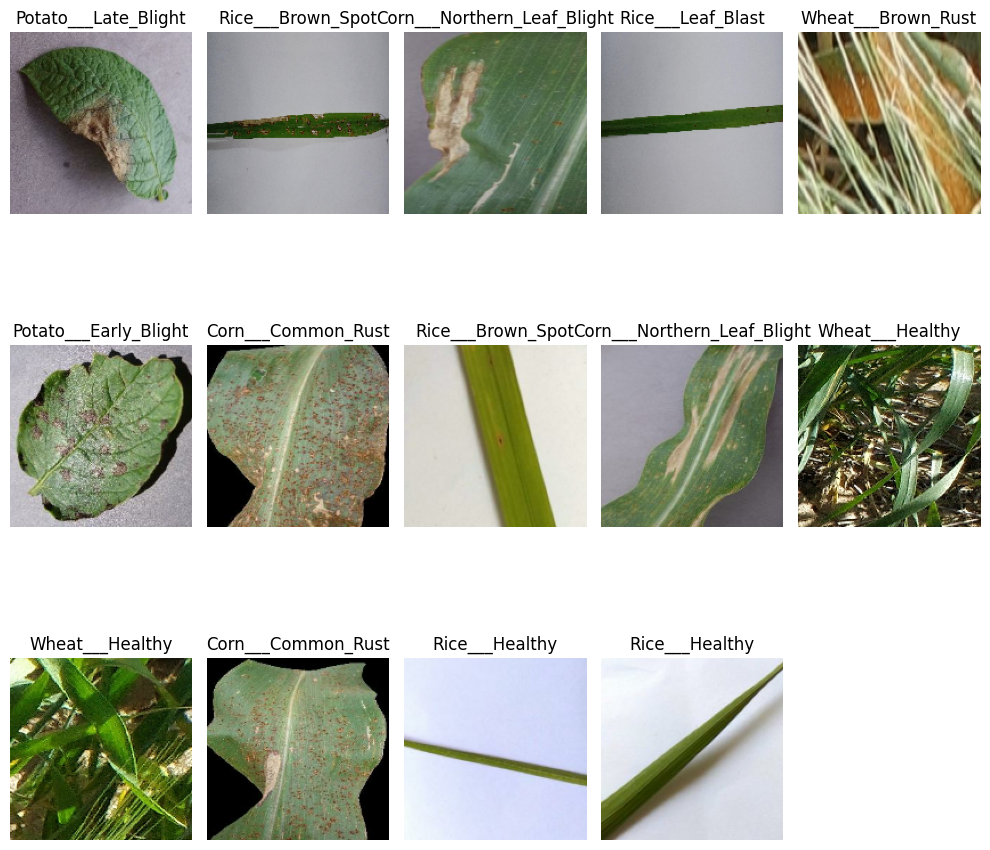

14

In [90]:
# Visualize a few images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(14, len(images))):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [91]:
# Prefetch for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [92]:
# Data augmentation
def data_augmenter():
    return tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.05),
        Rescaling(1./255)
    ])
data_augmentation = data_augmenter()

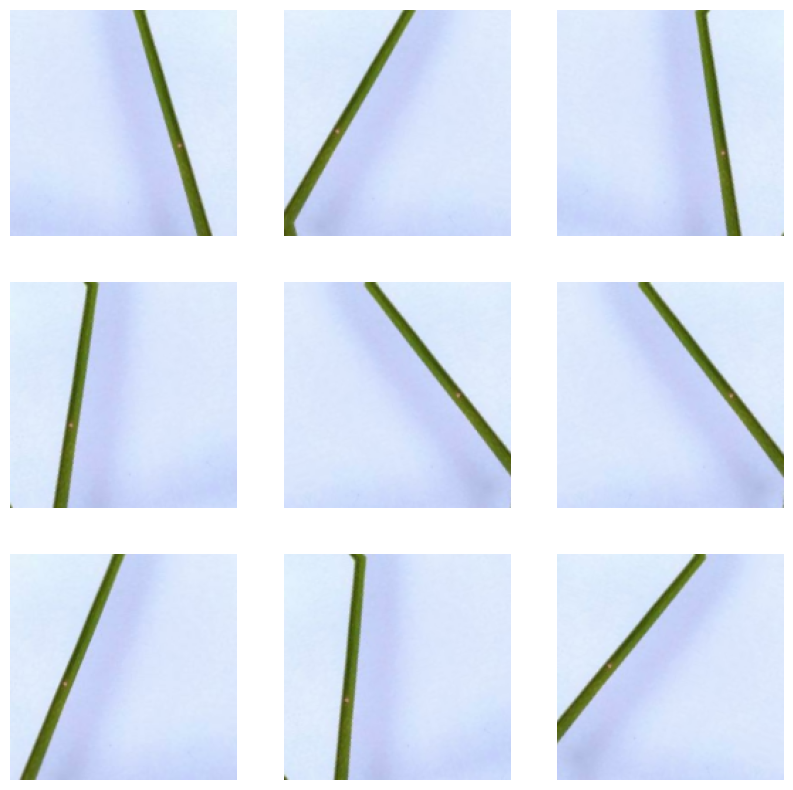

In [93]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [44]:
# Model setup: Transfer learning with MobileNetV2
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
'''
What does include_top=True do?
It means the model includes the final dense classification layer (the "top") that was trained on ImageNet's 1000 classes.

If you set weights='imagenet', the final layer is set up to predict ImageNet classes, not your custom classes.
------------------------
Can you train your model?
No, not directly for your dataset:
If you use include_top=True and weights='imagenet', the output layer is fixed for 1000 ImageNet classes, not your dataset’s classes.

You can technically "train" (fit) the model if you add more layers on top, but with include_top=True and base_model.trainable = False, you can't adapt it to your own classes or fine-tune it for your data.

Best practice: For transfer learning on your own dataset, use include_top=False, add your own classification head (Dense layer with correct number of classes), and then train that head.
--------------------
Can you test or evaluate the model on your data?
You can call model.evaluate() on your data, but the accuracy will be meaningless unless your dataset has the same 1000 classes as ImageNet, in the same order.

If your data is not ImageNet-formatted, the predictions will not match your labels, so accuracy will be very low or random.
'''
############
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)
'''
The last 2 layers called top layers are responsible of the classification in the model. We have put include_top=True here
'''
#############

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

#Shows the different label probabilities in one tensor
label_batch

global_average_pooling2d_1
predictions
(32, 1000)


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 4,  7,  4,  2,  9,  9, 11,  9, 13,  9, 13,  0,  0,  0,  2, 12,  4,
        6, 12, 12, 11,  6,  1, 11, 10, 10,  0,  4,  7, 11, 10,  8],
      dtype=int32)>

In [46]:
base_model.compile(
    optimizer='adam',                 # or any optimizer you like
    loss='sparse_categorical_crossentropy',  # match your label format
    metrics=['accuracy']
)

# For validation data
val_loss, val_acc = base_model.evaluate(validation_dataset)

# For train data
train_loss, train_acc = base_model.evaluate(train_dataset)

'''
The numbers 41 (for validation) and 326 (for train) that you see during model.evaluate() are the
number of batches processed during evaluation for each dataset.

Validation set has about 41 × batch size images.
Train set has about 326 × batch size images.
As we see the accuracy is 0, since our data is on crops, while the defaul output classes of MobileNet is for another data
'''

41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0000e+00 - loss: 9.1643
326/326 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.0000e+00 - loss: 9.1999


In [47]:
#Just checking 15 classes of base_model without training to confirm that since our classes
# are very different from output classes of MobileNet (without training) our accuracy is 0.
import json

# Download the mapping file for ImageNet class indices to human-readable labels
labels_path = tf.keras.utils.get_file(
    'imagenet_class_index.json',
    'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
)

with open(labels_path) as f:
    class_dict = json.load(f)

# Print all class names
for i in range(15):
    print(f"{i}: {class_dict[str(i)][1]}")


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
0: tench
1: goldfish
2: great_white_shark
3: tiger_shark
4: hammerhead
5: electric_ray
6: stingray
7: cock
8: hen
9: ostrich
10: brambling
11: goldfinch
12: house_finch
13: junco
14: indigo_bunting


In [75]:
# Re-making model but allowing it to be trainable
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Confirm that the last 2 layers are now different from previous.
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

Conv_1_bn
out_relu


In below code we are **not** using `x = base_model.output`.
Instead, we are using the **Functional API**, where we pass the input tensor step-by-step through each layer, including the base model:

```python
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
prediction_layer = tfl.Dense(1)
outputs = prediction_layer(x)
```


### **What’s the difference?**

- **`x = base_model.output`:**
This is used when you are building a new model by connecting layers to the output of an existing model.
Example:

```python
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
```

Here, you are not passing data through the base model in real time; you are just wiring up the computation graph.
- **Your approach (`x = base_model(x, training=False)`):**
You are **passing the input tensor through the base model** as part of a new model's computation pipeline.
This is the recommended way when you want to add preprocessing or augmentation before the base model, or control how the base model behaves (e.g., freeze batch norm statistics)[^7][^8].


### **Why is this done?**

- By using `x = base_model(x, training=False)`, you can:
    - Apply preprocessing and augmentation before the base model.
    - Control training/inference mode for layers like BatchNormalization[^7].
    - Build a flexible pipeline for transfer learning.


### **Order in your code**

- You apply augmentation and preprocessing first.
- Then you pass the result through the base model.
- Then you apply pooling, dropout, and your final classification layer.


### **Summary Table**

| Approach | How Used | When/Why |
| :-- | :-- | :-- |
| `x = base_model.output` | Connect new layers to base model output | When building a model from outputs directly |
| `x = base_model(x, ...)` | Pass tensor through base model | When building a full pipeline with preprocessing, augmentation, or special control over training/inference mode |


---

**Key point:**

- `x = base_model.output` is used for wiring up new layers to the output of a pre-built model.
- In your code, you are passing data through the base model as part of a new model pipeline, which is more flexible and recommended for transfer learning with preprocessing and augmentation[^7][^8].


[^1]: https://www.kaggle.com/code/nadaahassan/transfer-learning-with-mobilenetv2

[^2]: https://github.com/EhabR98/Transfer-Learning-with-MobileNetV2/blob/main/README.md

[^3]: https://stackoverflow.com/questions/75666846/i-am-applying-transfer-learning-for-my-regression-problem-i-am-using-mobilenetv

[^4]: https://keras.io/api/applications/mobilenet/

[^5]: https://discuss.ai.google.dev/t/about-mobilenet-v2-base-output-shape/31941

[^6]: https://stackoverflow.com/questions/67949558/what-is-the-difference-between-model-get-layer-and-model-get-layer-output

[^7]: https://www.tensorflow.org/tutorials/images/transfer_learning

[^8]: https://keras.io/guides/transfer_learning/

[^9]: https://www.tensorflow.org/guide/keras/sequential_model

[^10]: https://stackoverflow.com/questions/68463498/how-to-display-the-layers-of-a-pretrained-model-instead-of-a-single-entry-in-mod



In [94]:
# create the input layer (Same as the imageNetv2 input size)
inputs = tf.keras.Input(shape=IMG_SHAPE)

# apply data augmentation to the inputs
x = data_augmentation(inputs)

# set training to False to avoid keeping track of statistics in the batch norm layer
x = base_model(x, training=False)

# add the new Binary classification layers
# use global avg pooling to summarize the info in each channel
x = GlobalAveragePooling2D()(x)

x = Dropout(0.2)(x)

output_tensor = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output_tensor)

In [95]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [96]:
EPOCHS = 5
STEPS_PER_EPOCH = 50
VAL_STEPS = 20

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3960 - loss: 1.8633 - val_accuracy: 0.8156 - val_loss: 0.4961
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7742 - loss: 0.5904 - val_accuracy: 0.8687 - val_loss: 0.3591
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8363 - loss: 0.4452 - val_accuracy: 0.8828 - val_loss: 0.3008
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8352 - loss: 0.4091 - val_accuracy: 0.8906 - val_loss: 0.2748
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8374 - loss: 0.3763 - val_accuracy: 0.8984 - val_loss: 0.2651


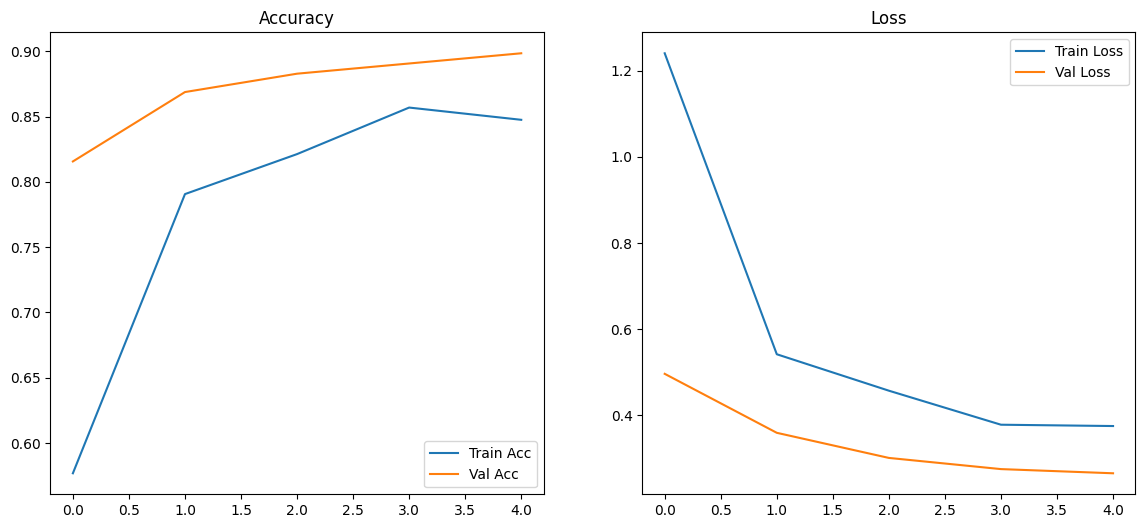

Validation accuracy: 0.88

Class-wise correct/incorrect predictions:
Corn___Common_Rust: 118 correct, 1 incorrect
Corn___Gray_Leaf_Spot: 39 correct, 12 incorrect
Corn___Healthy: 115 correct, 1 incorrect
Corn___Northern_Leaf_Blight: 88 correct, 10 incorrect
Potato___Early_Blight: 92 correct, 8 incorrect
Potato___Healthy: 12 correct, 3 incorrect
Potato___Late_Blight: 98 correct, 2 incorrect
Rice___Brown_Spot: 19 correct, 42 incorrect
Rice___Healthy: 145 correct, 4 incorrect
Rice___Leaf_Blast: 36 correct, 62 incorrect
Rice___Neck_Blast: 100 correct, 0 incorrect
Wheat___Brown_Rust: 80 correct, 10 incorrect
Wheat___Healthy: 111 correct, 1 incorrect
Wheat___Yellow_Rust: 88 correct, 4 incorrect

Classification Report:
                             precision    recall  f1-score   support

         Corn___Common_Rust       0.99      0.99      0.99       119
      Corn___Gray_Leaf_Spot       0.83      0.76      0.80        51
             Corn___Healthy       0.97      0.99      0.98       116
Co

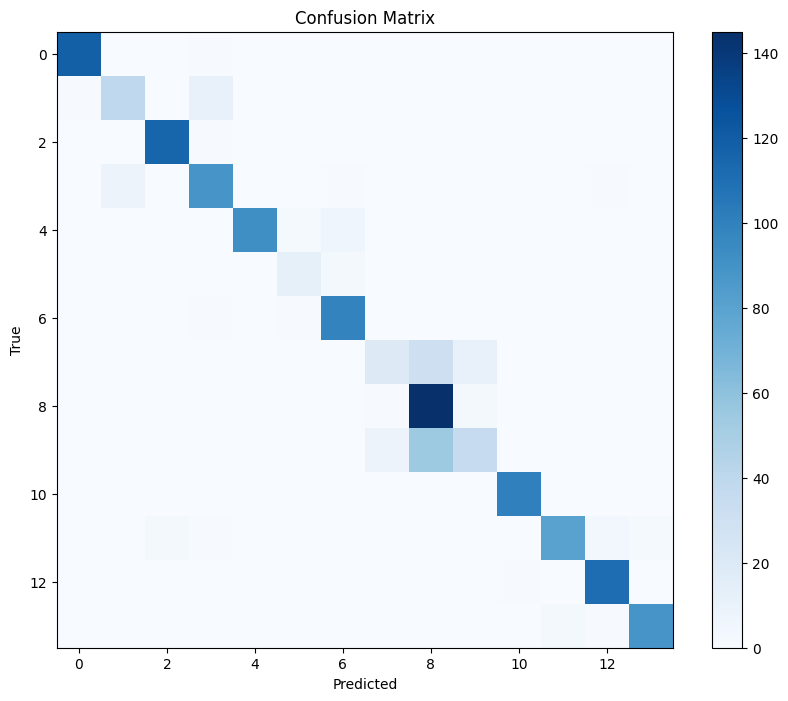

In [105]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

def evaluate_and_report(model, validation_dataset):
    # Get class labels
    class_labels = validation_dataset.class_names

    # Get true labels
    y_true = []
    for _, labels in validation_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Get predictions
    y_pred = model.predict(validation_dataset, verbose=0)
    if y_pred.shape[-1] > 1:
        y_pred_classes = np.argmax(y_pred, axis=1)
    else:
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()

    # Print overall validation accuracy
    val_loss, val_acc = model.evaluate(validation_dataset, verbose=0)
    print(f"Validation accuracy: {val_acc:.2f}")

    # Per-class correct/incorrect
    print("\nClass-wise correct/incorrect predictions:")
    for idx, class_name in enumerate(class_labels):
        class_indices = np.where(y_true == idx)[0]
        correct = np.sum(y_pred_classes[class_indices] == idx)
        incorrect = len(class_indices) - correct
        print(f"{class_name}: {correct} correct, {incorrect} incorrect")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.show()

# Usage:
plot_training_history(history)
evaluate_and_report(model, validation_dataset)


In [98]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation accuracy: {val_acc:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9052 - loss: 0.2562
Validation accuracy: 0.88
